In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Анализ тональности отзывов на товары Wildberries

# Установка моделей, импорт библиотек

In [4]:
!pip install datasets

In [5]:
!pip install compress-fasttext

  Preparing metadata (setup.py) ... done
  Created wheel for compress-fasttext: filename=compress_fasttext-0.1.4-py3-none-any.whl size=16096 sha256=741dabb978be0498c65a826484d787f9365a7b1149f85facbc7013b4c20c2acb
  Stored in directory: /root/.cache/pip/wheels/ef/0f/e8/5873a842310e96066067d9300281979b4a7d74b46d938f440e
Successfully built compress-fasttext


In [6]:
!pip install emoji==2.10.0

In [7]:
from datasets import load_dataset
from datasets import get_dataset_split_names
from datasets import get_dataset_config_names

In [8]:
import emoji
import os
import re
import compress_fasttext
import numpy as np
import pandas as pd
import random
import time

In [9]:
import nltk
nltk.download("stopwords")
from nltk.tokenize import word_tokenize
from collections import defaultdict
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
import torch
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler,
                              SequentialSampler)
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
import wordcloud
from collections import Counter

In [12]:
from transformers import AutoModel, AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Загрузка датасетов

## Загрузка датасета для обучения и оценки моделей.
[Датасет для обучения и оценки - это RuReviews: An Automatically Annotated Sentiment Analysis Dataset for Product Reviews in Russian](https://github.com/sismetanin/rureviews/blob/master/women-clothing-accessories.3-class.balanced.csv)

> @INPROCEEDINGS{Smetanin-SA-2019,
> author={Sergey Smetanin and Michail Komarov},
> booktitle={2019 IEEE 21st Conference on Business Informatics (CBI)},
> title={Sentiment Analysis of Product Reviews in Russian using Convolutional Neural Networks},
> year={2019},
> volume={01},
> number={},
> pages={482-486},
> doi={10.1109/CBI.2019.00062},
> ISSN={2378-1963},
> month={July}


In [13]:
! wget https://raw.githubusercontent.com/sismetanin/rureviews/master/women-clothing-accessories.3-class.balanced.csv

--2024-02-10 10:05:02--  https://raw.githubusercontent.com/sismetanin/rureviews/master/women-clothing-accessories.3-class.balanced.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21781685 (21M) [text/plain]
Saving to: 'women-clothing-accessories.3-class.balanced.csv'

women-clothing-acce 100%[===================>]  20.77M  --.-KB/s    in 0.1s    

2024-02-10 10:05:03 (155 MB/s) - 'women-clothing-accessories.3-class.balanced.csv' saved [21781685/21781685]



In [14]:
def to_mark(text):
    sent_dict = {"negative": 0, "neautral": 1, "positive": 2}
    return sent_dict[text]

In [15]:
df=pd.read_csv('/kaggle/working/women-clothing-accessories.3-class.balanced.csv', sep='\t')
df['sentiment'] = df['sentiment'].apply(to_mark)
df.head()

,review,sentiment
0,качество плохое пошив ужасный (горловина напер...,0
1,"Товар отдали другому человеку, я не получила п...",0
2,"Ужасная синтетика! Тонкая, ничего общего с пре...",0
3,"товар не пришел, продавец продлил защиту без м...",0
4,"Кофточка голая синтетика, носить не возможно.",0


In [16]:
df.to_csv('/kaggle/working/dp_women-clothing-accessories.3-class.balanced.csv', sep=',', index=False)

In [17]:
# перемешиваем
d = pd.read_csv('/kaggle/working/dp_women-clothing-accessories.3-class.balanced.csv')
df = d.sample(frac=1).reset_index(drop=True)
df.head()

,review,sentiment
0,слишком коротко,1
1,"Качество хорошее, размер подошел, пришло быстро",2
2,юбка класс. заказ шел (11.11.17-11.01.18) ткан...,2
3,"Отличные лосины, тёплые, мягкие. Ничем не пахн...",2
4,На бёдра 97 размер L мал!!! Правда сдаётся мне...,1


In [18]:
texts = np.array(df['review'])
labels = np.array(df['sentiment'])

## Загрузка датасета для проверки качества модели

In [110]:
from huggingface_hub import notebook_login
notebook_login()

In [19]:
! wget https://huggingface.co/datasets/TrainingDataPro/russian-marketplace-reviews-e-commerce-dataset/resolve/main/data_reviews.csv?download=true

--2024-02-10 10:05:06--  https://huggingface.co/datasets/TrainingDataPro/russian-marketplace-reviews-e-commerce-dataset/resolve/main/data_reviews.csv?download=true
Resolving huggingface.co (huggingface.co)... 18.172.134.24, 18.172.134.4, 18.172.134.124, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200355 (196K) [text/plain]
Saving to: 'data_reviews.csv?download=true'

data_reviews.csv?do 100%[===================>] 195.66K  --.-KB/s    in 0.03s   

2024-02-10 10:05:06 (5.83 MB/s) - 'data_reviews.csv?download=true' saved [200355/200355]



In [20]:
df_to_pred = pd.read_csv('/kaggle/working/data_reviews.csv?download=true')
df_to_pred.head()

,product_url,product_title,user_nickname,comment_date,comment_stars,comment_text,comment_likes_count,comment_dislikes_count
0,https://www.wildberries.ru/catalog/38709879/de...,Darya Selskaya / Рубашка офисная оверсайз,Нина,"11 марта, 18:39",5,"Качество отличное, так же ,как и пошив. Все а...",0,0
1,https://www.wildberries.ru/catalog/147914403/d...,Lee uliana / Брюки женские классические клеш в...,Александр,"13 марта, 23:02",5,"Отличные брюки. Ношу 48 размер, брюки взяла 46...",4,0
2,https://www.wildberries.ru/catalog/147653643/d...,Bio Connection / Пальто женское весна оверсайз...,Жуков Евгений,"01 марта, 21:21",5,"Спасибо, продавцу за быструю доставку, упаковк...",2,0
3,https://www.wildberries.ru/catalog/126760883/d...,Lovely Lady / Свитер женский оверсайз с принто...,Эвелина,"13 марта, 19:51",5,"свитер просто БОМБАААА я счастлива) мягенький,...",1,0
4,https://www.wildberries.ru/catalog/139844236/d...,Black Dragon / Джинсы женские серые бананы с в...,Евгения,"26 февраля, 14:16",5,Большимерят. Качество отличное,0,0


# 2. EDA и препроцессинг данных

## EDA обучающего датасета

In [21]:
df.info() # Обучающий датасет: 2 столбца, 90 тыс. записей, пропусков нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     90000 non-null  object
 1   sentiment  90000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ MB


In [20]:
# Соотношение классов: датасет сбалансирован
df['sentiment'].value_counts()

sentiment
0    30000
1    30000
2    30000
Name: count, dtype: int64

## EDA датасета для Inference

In [22]:
df_to_pred.rename(columns={'comment_text': 'review'}, inplace=True)

In [23]:
df_to_pred['comment_stars'].value_counts() #реальные отзывы несбалансированы, оценки - по 5-балльной шкале

comment_stars
5    484
4     23
1     19
3     16
2      9
Name: count, dtype: int64

### Удаление смайликов, переименование столбцов, перевод оценок из 5-балльной в 3-балльную шкалу, сохранение предобработанного датасета для Inference

In [25]:
def remove_emoji(text: str) -> str:
    """Вспомогательная функция для удаления смайликов из текста
    Args: text: str - исходный текст
    Return: str - текст без смайликов"""
    # Паттерн для поиска emoji
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # эмодзи с улыбками
                               u"\U0001F300-\U0001F5FF"  # эмодзи с надписями и символами
                               u"\U0001F680-\U0001F6FF"  # транспортные эмодзи
                               u"\U0001F1E0-\U0001F1FF"  # флаги стран
                               u"\U00002500-\U00002BEF"  # китайские иероглифы
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u200d"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\u3030"
                               u"\ufe0f"
                               "]+", flags=re.UNICODE)

    # Удаление emoji из текста
    return emoji_pattern.sub(r'', text)

In [27]:
df_to_pred['product'] = df_to_pred['product_title'].apply(lambda x: x.split('/')[1].strip() if '/'in x else x)
df_to_pred['brand'] = df_to_pred['product_title'].apply(lambda x: 'NoName' if '/' not in x else x.split('/')[0].strip())

df_to_pred['emo']=df_to_pred['review'].apply(lambda x: emoji.distinct_emoji_list(x))
df_to_pred['emo']= df_to_pred['emo'].apply(lambda x:', '.join(x))

df_to_pred['review']=df_to_pred['review'].apply(remove_emoji)

df_to_pred.rename(columns={'comment_stars': 'sentiment'}, inplace=True)


In [28]:
def mark_to_label(number):
    """Перевод оценок по 5 балльной шкале в оценки по 3-балльной шкале:
    1 и 2 - негативные отзывы (0),
    3 - нейтральные отзывы (1),
    4 и 5 - позитивные отзывы (2)"""
    if number < 3:
        return 0
    elif number == 3:
        return 1
    else:
        return 2

In [29]:
df_to_pred['sentiment'] = df_to_pred['sentiment'].apply(mark_to_label)

In [30]:
df_to_pred['sentiment'].value_counts() #реальные отзывы несбалансированы, но нам это не важно тк этот датасет используется только для inference

sentiment
2    507
0     28
1     16
Name: count, dtype: int64

In [28]:
# Распределение отзывов по брендам
df_to_pred['brand'].value_counts()

brand
Me TradeMark           7
ARAVIA Laboratories    4
ARAVIA Professional    4
NEWSKY                 3
Carpet-Gold            3
                      ..
Текстилево             1
HousesStore            1
Дом'ОК                 1
GRINIX                 1
Стальные решения       1
Name: count, Length: 482, dtype: int64

In [29]:
# ТOP-10 товаров с максимальным количеством положительных отзывов
df_to_pred[df_to_pred['sentiment'] == 2]['product'].value_counts()[:10] # Положительные

product
Шары хром. Воздушные шарики набор 50 шт. хромовые, металлик…    3
Ковер комнатный 160х230 см в гостиную                           3
Зарядное устройство Блок питания для iPhone для Android         3
Английская магниевая соль Epsom 5 кг                            2
Наушники беспроводные A.Pods Pro 2                              2
Лубрикант на водной основе 18+ интимный                         2
Костюм демисезонный детский, куртка и полукомбинезон            2
Караоке на флешке 1000 песен на usb накопителе                  2
Мультитул туристический тактический армейский пассатижи         2
Наушники беспроводные A.Pods 3 для iPhone для Android           2
Name: count, dtype: int64

In [30]:
# ТOP-10 товаров с максимальным количеством отрицательных отзывов
df_to_pred[df_to_pred['sentiment'] == 0]['product'].value_counts()[:10] # Отрицательные

product
Бандаж для беременных 4 в 1 Послеродовой дородовой корсет     1
Джемпер поло, женский джемпер теплый, кофта                   1
Брюки женские классические широкие                            1
Туфли из натуральной кожи                                     1
Набор декоративной косметики для девочек 28*34*6 см           1
Кружка на ножках белая                                        1
Плафон для люстры белый стеклянный Е27                        1
Массажер для спины шеи и плеч                                 1
Бижутерия Набор для создания браслетов Подарок для девочки    1
Зеркало карманное тонкое складное двойное с увеличением       1
Name: count, dtype: int64

### Cписок наиболее часто испольуемых слов для каждой категории товара с положительными оценками (с построением WordClowd) 

In [31]:
stopwords = stopwords.words("russian")

In [31]:
def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()

    return s

In [32]:
texts_to_pred = [text_preprocessing(text) for text in df_to_pred['review'].values]

TypeError: argument of type 'LazyCorpusLoader' is not iterable

In [36]:
plt.rcParams['figure.figsize'] = [16, 9]

def create_ngrams(token_list, nb_elements):
    """
    Получение n-грамм для списка токенов

    Args:
      token_list : list - Список токенов
      nb_elements : int  n-gram

    Returns: Generator - генератор n-grams
    """
    ngrams = zip(*[token_list[index_token:] for index_token in range(nb_elements)])
    return (' '.join(ngram) for ngram in ngrams)

In [37]:
def frequent_words(list_words, ngrams_number=1, number_top_words=10):
    """
    Create n-grams for list of tokens

    Args:
      list_worda: list - Список слов
      ngrams_number : int - К-во токенов в n-грамме
      number_top_words : int - длина  списка top_words

    Returns
      DataFrame:датафрейм с словами и частотами.
    """
    frequent = []
    if ngrams_number == 1:
        pass
    elif ngrams_number >= 2:
        list_words = create_ngrams(list_words, ngrams_number)
    else:
        raise ValueError('number of n-grams should be >= 1')
    counter = Counter(list_words)
    frequent = counter.most_common(number_top_words)
    return frequent

In [41]:
from wordcloud import WordCloud

In [42]:
def make_word_cloud(text_or_counter, stop_words=None):
    """ Построение облака слов"""
    if isinstance(text_or_counter, str):
        word_cloud = WordCloud(stopwords=stop_words).generate(text_or_counter)
    else:
        if stop_words is not None:
            text_or_counter = Counter(word for word in text_or_counter if word not in stop_words)
            word_cloud = WordCloud(stopwords=stop_words).generate_from_frequencies(text_or_counter)
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.show()

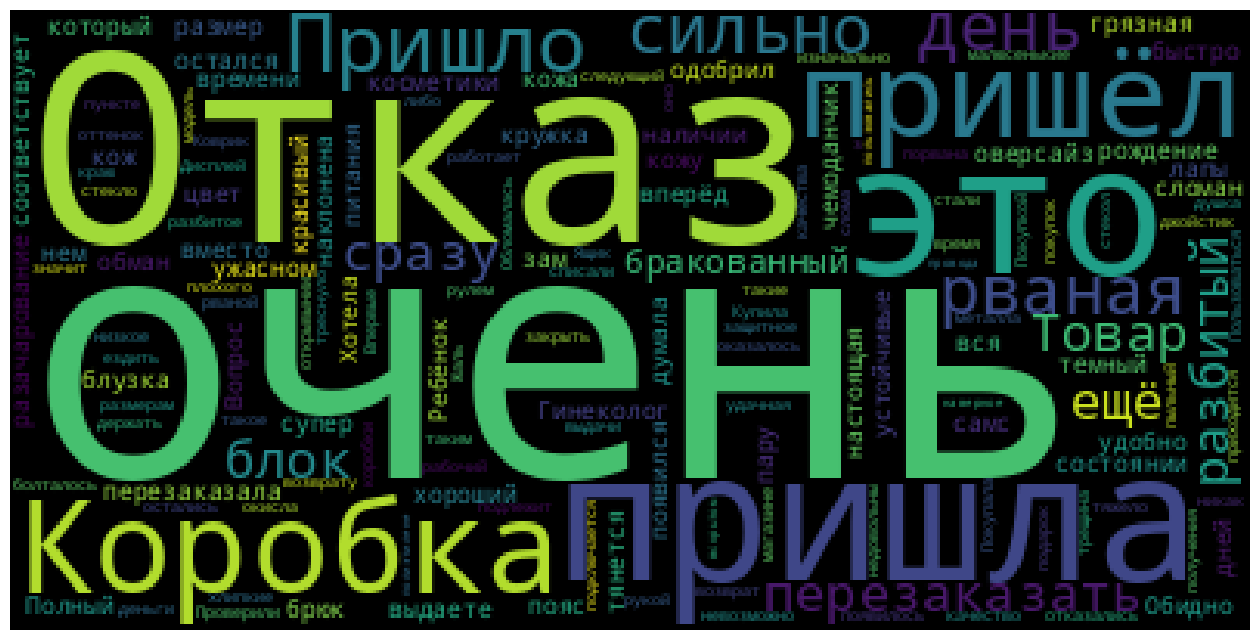

In [43]:
# Облако слов для отрицательных отзывов
text_data = ' '.join(df_to_pred[df_to_pred['sentiment'] == 0]['review'])
make_word_cloud(text_data, stop_words=stopwords)

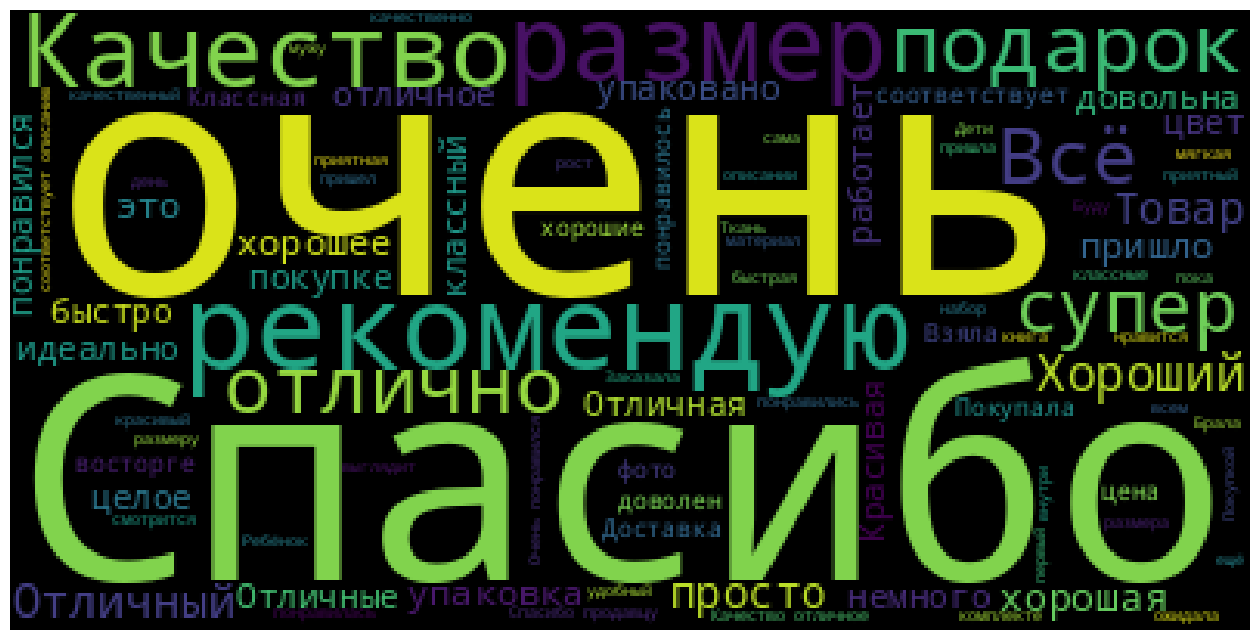

In [44]:
# Облако слов для положительных отзывов
text_data = ' '.join(df_to_pred[df_to_pred['sentiment'] == 2]['review'])
make_word_cloud(text_data, stop_words=stopwords)

## Препроцессинг данных

На этапе обучения о иоценки моделей все манипуляции проводятся с данными из обучающего датасета

In [45]:
# texts = np.array(df['review'])
# labels = np.array(df['sentiment'])

In [34]:
def load_pretrained_vectors(word2idx, ft_model):
    """Load pretrained vectors and create embedding layers.

    Args:
        word2idx (Dict): словарь из корпуса текстов
        ft_model (CompressedFastTextKeyedVectors): Compressed FastText model

    Returns:
        embeddings (np.array): матрица мбеддингов размером (N, d),
        где N -размер словаря word2idx,  d - размерность эмбеддинга
    """

    print("Loading pretrained vectors...")

    # Инициализация эмбеддингов случайными числами
    d = ft_model.vector_size
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['<pad>']] = np.zeros((d,))

    # Загрузка предобученных векторов
    count = 0
    for word in tqdm(word2idx.keys()):
        if word in ft_model:
            count += 1
            embeddings[word2idx[word]] = ft_model[word]

    print(f"Найдено {count} / {len(word2idx)} предобученных векторов.")

    return embeddings

In [35]:
def tokenize(texts: list[str]) -> tuple[list[list[str]], dict, int]:
    """Токенизация текста, создание словаря, поиск максимальной длины последовательности токенов.

    Args:
        texts (List[str]): список текстов

    Returns:
        tokenized_texts (List[List[str]]): Список списков токенов
        word2idx (Dict): Словарь построенный из корпуса текста
        max_len (int): максимальная длина последовательности токенов
    """

    max_len = 0
    tokenized_texts = []
    word2idx = {}

    # Добавляем токены <pad> and <unk> к словарю
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1

    # Создаем словарь из корпуса, начиная с индекса 2
    idx = 2
    for sent in tqdm(texts):
        tokenized_sent = word_tokenize(sent)

        # Добавляем токенизированное предложение к списку ( тексту)
        tokenized_texts.append(tokenized_sent)

        # Добавляем новы токен к словарю `word2idx`
        for token in tokenized_sent:
            if token not in word2idx:
                word2idx[token] = idx
                idx += 1

        # ВЫчисляем новое значение `max_len`
        max_len = max(max_len, len(tokenized_sent))

    return tokenized_texts, word2idx, max_len

In [48]:
print("Tokenizing...\n")
tokenized_texts, word2idx, max_len = tokenize(texts)

Tokenizing...



  0%|          | 0/90000 [00:00<?, ?it/s]

In [49]:
tokenized_texts[0]

['Слишком',
 'огромная',
 '-',
 'ОГ',
 '160см',
 ',',
 'низ/подол',
 'аж',
 '150см',
 '!',
 'Даже',
 'на',
 'мой',
 '54',
 'размер',
 '(',
 '112-110-104',
 ')',
 'ужасно',
 '!',
 'Так',
 'носить',
 'невозможно',
 '-',
 'полнит',
 'раза',
 'в',
 '2',
 '!',
 'Придётся',
 'ушивать',
 'по',
 'бокам',
 ',',
 'чтобыз',
 'низ',
 'был',
 '124см',
 'хотя',
 'бы',
 '...',
 'А',
 'это',
 'расход',
 'времени',
 'и',
 'денег',
 '.',
 'Весь',
 'этот',
 'лишний',
 'дурацкий',
 'объём',
 ',',
 'что',
 'болтается',
 '-',
 'в',
 'основном',
 '-',
 'сзади',
 '-',
 'совершенно',
 'не',
 'видно',
 'на',
 'фото',
 'продавца',
 ',',
 'т.к',
 '.',
 'модель',
 'сняли',
 'только',
 'фронтально',
 '-',
 'спереди',
 '!',
 '!',
 '!',
 '(',
 '(',
 '(',
 '(']

In [50]:
def encode(tokenized_texts, word2idx, max_len) -> np.array(int):
    """Добавляем в каждое предложение токены <PAD> до достижения длины max_length,
    кодируем токены их индексом в словаре.

    Args:
        tokenized_texts (List[List[str]]): Список списков токенов
        word2idx (Dict): Словарь построенный из корпуса текста
        max_len (int): максимальная длина последовательности токенов
    Returns:
        input_ids (np.array): Массив индексов токенов размерностью (N, max_len).
        Будет подаваться на вход модели"""

    input_ids = []
    for tokenized_sent in tqdm(tokenized_texts):
        # Паддинг предложения до max_len
        tokenized_sent += ['<pad>'] * (max_len - len(tokenized_sent))

        # Кодироване токенов индексами input_ids из словаря word2idx
        input_id = [word2idx.get(token) for token in tokenized_sent]
        input_ids.append(input_id)

    return np.array(input_ids)

In [51]:
ft = compress_fasttext.models.CompressedFastTextKeyedVectors.load(
    'https://github.com/avidale/compress-fasttext/releases/download/gensim-4-draft/geowac_tokens_sg_300_5_2020-400K-100K-300.bin'
)

In [52]:
embeddings = load_pretrained_vectors(word2idx, ft)
embeddings = torch.tensor(embeddings)

Loading pretrained vectors...


  0%|          | 0/88444 [00:00<?, ?it/s]

Найдено 88444 / 88444 предобученных векторов.


In [53]:
input_ids = encode(tokenized_texts, word2idx, max_len)

  0%|          | 0/90000 [00:00<?, ?it/s]

# 3. Работа с моделями

## BaseLine: TFIDF

In [54]:
%%time
X_train, X_val, y_train, y_val = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels)

X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])

tf_idf = TfidfVectorizer(smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

CPU times: user 9.67 s, sys: 178 ms, total: 9.85 s
Wall time: 9.87 s


In [55]:
import warnings
warnings.filterwarnings("ignore")

In [56]:
lr_model = LogisticRegression(solver='saga',penalty='l1', max_iter=300, random_state=42)
lr_model.fit(X_train_tfidf, y_train)
y_pred = lr_model.predict(X_val_tfidf)
print(classification_report(y_pred, y_val, target_names =['negative', 'neautral', 'positive']))

              precision    recall  f1-score   support

    negative       0.70      0.73      0.72      5725
    neautral       0.66      0.62      0.64      6387
    positive       0.83      0.85      0.84      5888

    accuracy                           0.73     18000
   macro avg       0.73      0.73      0.73     18000
weighted avg       0.73      0.73      0.73     18000



## Модель CNN_NLP на базе сверточных слоев

### Разбиваем на train и val, загружаем в PyTorch DataLoader

In [57]:
filter_sizes = [2, 3, 4]
num_filters = [2, 2, 2]
batch_size = 50
num_classes = 3

In [58]:
def data_loader(train_inputs: np.array, val_inputs: np.array,
                train_labels: np.array, val_labels: np.array,
                batch_size: int) -> tuple[DataLoader, DataLoader]:
    """Преобразование обучающей и оценочной выборок в to torch.Tensors и загрузка в
    DataLoader.
    """

    # Преобразование в torch.Tensor
    train_inputs, val_inputs, train_labels, val_labels =\
    tuple(torch.tensor(data) for data in
          [train_inputs, val_inputs, train_labels, val_labels])

    # Создание DataLoader для train
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Создание DataLoader для val
    val_data = TensorDataset(val_inputs, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    return train_dataloader, val_dataloader

In [59]:
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids, labels, test_size=0.2, random_state=42, stratify=labels)
train_dataloader, val_dataloader = \
data_loader(train_inputs, val_inputs, train_labels, val_labels, batch_size=batch_size)

### Конструктор

In [60]:
class CNN_NLP(nn.Module):
    """An 1D Convulational Neural Network for Sentence Classification."""
    def __init__(self,
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 vocab_size=None,
                 embed_dim=300,
                 filter_sizes=[3, 4, 5],
                 num_filters=[100, 100, 100],
                 num_classes=3,
                 dropout=0.5):
        """
        Args:
            pretrained_embedding (torch.Tensor): ПРедобученные эмбеддинги размерностью
                (vocab_size, embed_dim).Optional
            freeze_embedding (bool): Установить False при тонкой настройке предобученных эмбеддингов
                . Default: False
            vocab_size (int): необходимо задать, если не используются предобученные эмбеддинги.
            embed_dim (int): Размерность эмбеддинга. НЕобходимо задать, если не используются 
                предобученные эмбеддинги. Default: 300
            filter_sizes (List[int]): Список размеров фильтров. Default: [3, 4, 5]
            num_filters (List[int]): Список кол-ва филтров, той же длины, что и `filter_sizes`. 
                Default: [100, 100, 100]
            n_classes (int): Кол-во классов. Default: 3
            dropout (float): Dropout rate. Default: 0.5
        """

        super(CNN_NLP, self).__init__()
        # Embedding Слой , куда подаютсяя эмбеддинги; они инициализируются случайным образом или загружаются уже предобученные
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        else:
            self.embed_dim = embed_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx=0,
                                          max_norm=5.0)
        # Сверточные слои
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        # Полносвязный слой и Dropout
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):
        """Perform a forward pass through the network.

        Args:
            input_ids (torch.Tensor): A tensor of token ids with shape
                (batch_size, max_sent_length)

        Returns:
            logits (torch.Tensor): Output logits with shape (batch_size,
                n_classes)
        """

        # Получаем эмбеддинги из `input_ids`. Размерность на выходе: (b, max_len, embed_dim)
        x_embed = self.embedding(input_ids).float()

        # Переформатируем `x_embed` для соотвествия размерности `nn.Conv1d`.
        # Размерность на выходе: (b, embed_dim, max_len)
        x_reshaped = x_embed.permute(0, 2, 1)

        # Слои CNN and ReLU. Размерность на выходе: (b, num_filters[i], L_out)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling. Размерность на выходе: (b, num_filters[i], 1)
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]

        # Конкатенация x_pool_list для заполнения полносвязного слоя.
        # Output shape: (b, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)

        # Вычисление логитов Output shape: (b, n_classes)
        logits = self.fc(self.dropout(x_fc))

        return logits

### Модуль для  инициализации модели

In [61]:
def initilize_model(pretrained_embedding=None,
                    freeze_embedding=False,
                    vocab_size=None,
                    embed_dim=300,
                    filter_sizes=[3, 4, 5],
                    num_filters=[100, 100, 100],
                    num_classes=3,
                    dropout=0.5,
                    learning_rate=0.01):
    """Инициализация модели и оптимизатора."""

    assert (len(filter_sizes) == len(num_filters)), "filter_sizes and \
    num_filters need to be of the same length."

    cnn_model = CNN_NLP(pretrained_embedding=pretrained_embedding,
                        freeze_embedding=freeze_embedding,
                        vocab_size=vocab_size,
                        embed_dim=embed_dim,
                        filter_sizes=filter_sizes,
                        num_filters=num_filters,
                        num_classes=3,
                        dropout=0.5)

    cnn_model.to(device)

    optimizer = optim.Adadelta(cnn_model.parameters(),
                               lr=learning_rate,
                               rho=0.95)

    return cnn_model, optimizer

### модули для обучения и оценки модели

In [62]:
# задаем функцию потерь
loss_fn = nn.CrossEntropyLoss()

In [53]:
def set_seed(seed_value=42):
    """Устанавливаем seed для генератора псевдослучайных числе."""

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [64]:
def train(model, optimizer, train_dataloader, val_dataloader=None, epochs=10):
    """Train the CNN model."""

    best_accuracy = 0

    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)

    for epoch_i in tqdm(range(epochs)):
        # =======================================
        #               Training
        # =======================================

        t0_epoch = time.time()
        total_loss = 0

        model.train()

        for step, batch in enumerate(train_dataloader):
            b_input_ids, b_labels = tuple(t.to(device) for t in batch)

            model.zero_grad()
            logits = model(b_input_ids)
            loss = loss_fn(logits, b_labels)
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        avg_train_loss = total_loss / len(train_dataloader)

        # =======================================
        #               Evaluation
        # =======================================
        if val_dataloader is not None:

            val_loss, val_accuracy = evaluate(model, val_dataloader)

            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy

            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")

    print("\n")
    print(f"Best accuracy: {best_accuracy:.2f}%.")

In [65]:
def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's
    performance on our validation set.
    """
    model.eval()

    val_accuracy = []
    val_loss = []

    for batch in val_dataloader:
        b_input_ids, b_labels = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            logits = model(b_input_ids)

        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        preds = torch.argmax(logits, dim=1).flatten()

        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [66]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
Device name: Tesla T4


### Вариант 1: Случайная инициализация векторов слов

In [67]:
# CNN-rand
set_seed(42)
cnn_rand, optimizer = initilize_model(vocab_size=len(word2idx),
                                      embed_dim=300,
                                      learning_rate=0.1,
                                      dropout=0.5)
train(cnn_rand, optimizer, train_dataloader, val_dataloader, epochs=10)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

   1    |   0.846756   |  0.713396  |   68.28   |   38.44  
   2    |   0.696042   |  0.657299  |   70.98   |   36.09  
   3    |   0.641766   |  0.633708  |   72.21   |   36.59  
   4    |   0.602567   |  0.620295  |   72.59   |   37.12  
   5    |   0.568971   |  0.613129  |   72.66   |   36.94  
   6    |   0.542003   |  0.606639  |   72.97   |   37.00  
   7    |   0.516310   |  0.607509  |   73.03   |   36.94  
   8    |   0.486884   |  0.607358  |   73.44   |   36.99  
   9    |   0.464050   |  0.611519  |   73.31   |   37.00  
  10    |   0.441509   |  0.614083  |   73.59   |   37.00  


Best accuracy: 73.59%.


### Вариант 2 - Используются compressed fastText эмбеддинги, которые замораживаются на период обучения

In [68]:
# CNN-static
set_seed(42)
cnn_static, optimizer = initilize_model(pretrained_embedding=embeddings,
                                        freeze_embedding=True,
                                        learning_rate=0.1,
                                        dropout=0.5)
train(cnn_static, optimizer, train_dataloader, val_dataloader, epochs=10)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

   1    |   0.771095   |  0.645921  |   71.35   |   16.29  
   2    |   0.633720   |  0.606074  |   73.05   |   16.30  
   3    |   0.600792   |  0.594889  |   73.74   |   16.29  
   4    |   0.576886   |  0.579090  |   74.58   |   16.25  
   5    |   0.560155   |  0.580313  |   74.70   |   16.26  
   6    |   0.546513   |  0.570385  |   74.93   |   16.26  
   7    |   0.532468   |  0.569710  |   74.96   |   16.25  
   8    |   0.519951   |  0.571398  |   74.72   |   16.23  
   9    |   0.507047   |  0.569679  |   75.03   |   16.27  
  10    |   0.495239   |  0.570171  |   75.04   |   16.28  


Best accuracy: 75.04%.


### Вариант 3: Тонкая настройка compressed fastText эмбеддингов в процессе обучения модели

In [69]:
# CNN-non-static
set_seed(42)
cnn_non_static, optimizer = initilize_model(pretrained_embedding=embeddings,
                                            freeze_embedding=False,
                                            learning_rate=0.1,
                                            dropout=0.5)
train(cnn_non_static, optimizer, train_dataloader, val_dataloader, epochs=10)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

   1    |   0.765036   |  0.637194  |   71.58   |   62.16  
   2    |   0.622674   |  0.594675  |   73.54   |   62.45  
   3    |   0.587626   |  0.584448  |   74.22   |   62.47  
   4    |   0.562387   |  0.567393  |   74.96   |   62.44  
   5    |   0.543500   |  0.569590  |   75.24   |   62.35  
   6    |   0.528639   |  0.560629  |   75.43   |   62.42  
   7    |   0.512062   |  0.558994  |   75.38   |   62.44  
   8    |   0.498808   |  0.560048  |   75.22   |   62.39  
   9    |   0.484404   |  0.559561  |   75.30   |   62.40  
  10    |   0.469828   |  0.559741  |   75.51   |   62.40  


Best accuracy: 75.51%.


### Вариант 4: используются предобученные эмбеддинги, полученные из модели SBERT

In [108]:
# возвращается усредненный эмбеддинг для каждого предложения в батче
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #Первый элемент model_output содержит эмбеддинги всех токенов
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [109]:
tokenizer = AutoTokenizer.from_pretrained("ai-forever/sbert_large_nlu_ru")
model = AutoModel.from_pretrained("ai-forever/sbert_large_nlu_ru")

#Tокенизируем предложения, получая последовательность токенов и маску внимания
encoded_input = tokenizer(texts, padding=True, truncation=True, max_length=64, return_tensors='pt')

#Вычисляем эмбеддинги для каждого токена
with torch.no_grad():
    model_output = model(**encoded_input)

#Получаем эмбеддинг каждого предложения,
# Выполняем усреднение, перемножая эмбеддинги на маску внимания, складывая и находя среднее
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

OSError: We couldn't connect to 'https://huggingface.co' to load this file, couldn't find it in the cached files and it looks like ai-forever/sbert_large_nlu_ru is not the path to a directory containing a file named config.json.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

In [ ]:
# CNN-SBERT
set_seed(42)
cnn_sbert, optimizer = initilize_model(pretrained_embedding=sentence_embeddings,
                                        freeze_embedding=True,
                                        learning_rate=0.1,
                                        dropout=0.5)
train(cnn_static, optimizer, train_dataloader, val_dataloader, epochs=10)

val_accuracy в модели 3 незначительно выше, чем в baseline и моделях 1 и 2. Однако затраты врмени на обучение почти в 5 раз выше! Оптимальным вариантом является модель 2

### Прогнозирование
Получим classification_report для оценочного датасета, чтобы сравнить с baseline.
Затем проверим качество на Inference - открытом датасете с huggingface:
[TrainingDataPro/russian-marketplace-reviews-e-commerce-dataset](https://huggingface.co/datasets/TrainingDataPro/russian-marketplace-reviews-e-commerce-dataset)

In [70]:
def predict(text, model=cnn_non_static.to("cpu"), max_len=62, flag=False):
    """Predict probability that a review is positive."""

    # Tokenize, pad and encode text
    tokens = word_tokenize(text.lower())
    padded_tokens = tokens + ['<pad>'] * (max_len - len(tokens))
    input_id = [word2idx.get(token, word2idx['<unk>']) for token in padded_tokens]

    # Convert to PyTorch tensors
    input_id = torch.tensor(input_id).unsqueeze(dim=0)

    # Compute logits
    logits = model.forward(input_id)

    #  Compute probability
    probs = F.softmax(logits, dim=1).squeeze(dim=0)
    if flag:
        print(f"This review is  {probs[0] * 100:.2f}% negative, {probs[1] * 100:.2f}% neutral & {probs[2] * 100:.2f}% positive.")
    return np.argmax(probs.detach().numpy())

In [71]:
model_list = []
model_list.append(("CNN-rand", cnn_rand))
model_list.append(("CNN-static", cnn_static))
model_list.append(("CNN-non-static", cnn_non_static))
model_list.append(("CNN-sbert", cnn_sbert))

In [78]:
train_t,val_t, train_l, val_l = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels)

In [82]:
# Получим classification_report для обучающего датасета, чтобы сравнить с baseline.
for name, model in model_list:
    predictions = []
    for text, label in zip(val_t, val_l):
        predictions.append(predict(text, model= model.to("cpu"), max_len=256, flag=False))
    print(f'-----{name}--------')
    print(classification_report(np.array(predictions),val_l, target_names=['negative', 'neutral', 'positive']))
    print()

-----CNN-rand--------
              precision    recall  f1-score   support

    negative       0.81      0.82      0.82      5929
     neutral       0.79      0.75      0.77      6307
    positive       0.90      0.94      0.92      5764

    accuracy                           0.84     18000
   macro avg       0.84      0.84      0.84     18000
weighted avg       0.83      0.84      0.84     18000


-----CNN-static--------
              precision    recall  f1-score   support

    negative       0.79      0.78      0.78      6056
     neutral       0.73      0.70      0.72      6248
    positive       0.88      0.92      0.90      5696

    accuracy                           0.80     18000
   macro avg       0.80      0.80      0.80     18000
weighted avg       0.80      0.80      0.80     18000


-----CNN-non-static--------
              precision    recall  f1-score   support

    negative       0.81      0.78      0.79      6181
     neutral       0.74      0.72      0.73      6125

In [73]:
# Проверим качество на Inference - открытом датасете с huggingface
texts_to_pred = np.array(df_to_pred['review'])
labels_to_pred = np.array(df_to_pred['sentiment'])

In [83]:
for name, model in model_list:
    predictions = []
    for text, label in zip(texts_to_pred, labels_to_pred):
        predictions.append(predict(text, model= model.to("cpu"), max_len=256, flag=False))
    print(f'-----{name}--------')
    print(classification_report(np.array(predictions),labels_to_pred, target_names=['negative', 'neutral', 'positive']))
    print()

-----CNN-rand--------
              precision    recall  f1-score   support

    negative       0.29      0.42      0.34        19
     neutral       0.69      0.11      0.19       100
    positive       0.84      0.99      0.91       432

    accuracy                           0.81       551
   macro avg       0.60      0.51      0.48       551
weighted avg       0.79      0.81      0.76       551


-----CNN-static--------
              precision    recall  f1-score   support

    negative       0.57      0.42      0.48        38
     neutral       0.44      0.09      0.15        76
    positive       0.86      0.99      0.92       437

    accuracy                           0.83       551
   macro avg       0.62      0.50      0.52       551
weighted avg       0.78      0.83      0.78       551


-----CNN-non-static--------
              precision    recall  f1-score   support

    negative       0.61      0.46      0.52        37
     neutral       0.50      0.11      0.18        71

Получился интересный результат - качество прогноза на тестовом датасете выше с самой первой моделью. Видимо, причина в том, что эмбеддинги, на которых обучалась 2 и 3 модели, строились уже исходя из конкретного корпуса текста, который значиетльно меньше, чем корпус, на котором обучалась модель fasttext

## Fine-tuning предобученной модели distilbert с huggingface

In [37]:
from transformers import DistilBertModel, DistilBertTokenizer
from torch.utils.data import Dataset, DataLoader

In [83]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 8
EPOCHS = 5
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

In [38]:
class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        review = str(self.data.review[index])
        review = " ".join(review.split())
        inputs = self.tokenizer.encode_plus(
            review,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.sentiment[index], dtype=torch.long)
        }

    def __len__(self):
        return self.len

In [84]:
# Создаем датасет и даталоадер
train_size = 0.8
train_dataset=df.sample(frac=train_size,random_state=42)
test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = Triage(train_dataset, tokenizer, MAX_LEN)
testing_set = Triage(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (90000, 2)
TRAIN Dataset: (72000, 2)
TEST Dataset: (18000, 2)


In [85]:
inference_set = Triage(df_to_pred, tokenizer, MAX_LEN)

In [86]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }
# train_dataloader = DataLoader(training_set, **train_params)
# val_dataloader = DataLoader(testing_set, **test_params)
training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [88]:
inference_params = {'batch_size':1,
                'shuffle': False,
                'num_workers': 0
                }
inference_loader = DataLoader(inference_set)

In [66]:
# Добавляем drop out и dense layer к исходной модели distil bert (без головы).

class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 3)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [67]:
model = DistillBERTClass()
model.to(device)

DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(i

In [68]:
# Оптимизатор и функция потерь
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [69]:
# Функция для вычисления accuracy модели
def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [81]:
def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return

In [82]:
def valid(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss = 0.; nb_tr_steps = 0; nb_tr_examples=0
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accu(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples +=targets.size(0)

            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 5000 steps: {loss_step}")
                print(f"Validation Accuracy per 5000 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")

    return epoch_accu

In [90]:
best_model = None
best_epoch = 0
best_accuracy = 0.
for epoch in range(EPOCHS):
    train(epoch)
    acc = valid(model, testing_loader)
    if acc > best_accuracy:
        best_accuracy = acc
        best_epoch = epoch
        best_model = model
print("Accuracy on test data = %0.2f%%" % best_accuracy)

0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.7170838713645935
Training Accuracy per 5000 steps: 75.0
The Total Accuracy for Epoch 0: 77.11527777777778
Training Loss Epoch: 0.5167543765256802
Training Accuracy Epoch: 77.11527777777778


0it [00:00, ?it/s]

Validation Loss per 5000 steps: 0.46375834941864014
Validation Accuracy per 5000 steps: 62.5
Validation Loss Epoch: 0.5808510256146805
Validation Accuracy Epoch: 74.68888888888888


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.2600049078464508
Training Accuracy per 5000 steps: 93.75
The Total Accuracy for Epoch 1: 78.12083333333334
Training Loss Epoch: 0.49361469055546653
Training Accuracy Epoch: 78.12083333333334


0it [00:00, ?it/s]

Validation Loss per 5000 steps: 0.22856710851192474
Validation Accuracy per 5000 steps: 87.5
Validation Loss Epoch: 0.5613842266044683
Validation Accuracy Epoch: 75.17777777777778


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.5083996057510376
Training Accuracy per 5000 steps: 75.0
The Total Accuracy for Epoch 2: 79.34027777777777
Training Loss Epoch: 0.46934438558419544
Training Accuracy Epoch: 79.34027777777777


0it [00:00, ?it/s]

Validation Loss per 5000 steps: 0.4255833625793457
Validation Accuracy per 5000 steps: 87.5
Validation Loss Epoch: 0.5740802217159007
Validation Accuracy Epoch: 75.06111111111112


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.49420151114463806
Training Accuracy per 5000 steps: 81.25
The Total Accuracy for Epoch 3: 80.37777777777778
Training Loss Epoch: 0.44683335837721827
Training Accuracy Epoch: 80.37777777777778


0it [00:00, ?it/s]

Validation Loss per 5000 steps: 0.12866725027561188
Validation Accuracy per 5000 steps: 100.0
Validation Loss Epoch: 0.6155428963071771
Validation Accuracy Epoch: 74.47777777777777


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.4353117048740387
Training Accuracy per 5000 steps: 93.75
The Total Accuracy for Epoch 4: 81.63194444444444
Training Loss Epoch: 0.4227491622782416
Training Accuracy Epoch: 81.63194444444444


0it [00:00, ?it/s]

Validation Loss per 5000 steps: 0.48388487100601196
Validation Accuracy per 5000 steps: 62.5
Validation Loss Epoch: 0.6129577338761754
Validation Accuracy Epoch: 74.37222222222222
Accuracy on test data = 75.18%


In [91]:
acc = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

0it [00:00, ?it/s]

Validation Loss per 5000 steps: 0.7325621247291565
Validation Accuracy per 5000 steps: 75.0
Validation Loss Epoch: 0.6129577347594831
Validation Accuracy Epoch: 74.37222222222222
Accuracy on test data = 74.37%


In [92]:
output_model_file = '/kaggle/working/pytorch_distilbert_news.bin'
output_vocab_file = '/kaggle/working/vocab_distilbert_news.bin'

model_to_save = model
torch.save(model_to_save, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('All files saved')

All files saved


In [106]:
output_model_file = '/kaggle/working/best_distilbert_news.bin'
output_vocab_file = '/kaggle/working/best_vocab_distilbert_news.bin'

model_to_save = best_model
torch.save(model_to_save, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('All files saved')

All files saved


## Inference

In [101]:
def predict_distilbert(inference_dataloader, model):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in inference_dataloader:
            input_ids = batch['ids'].to('cpu')
            attention_mask = batch['mask'].to('cpu')
            outputs = model(input_ids, attention_mask)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
    return predictions

In [102]:
predictions = predict_distilbert(inference_loader, model.to('cpu'))

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [105]:
print(classification_report(predictions,df_to_pred['sentiment'], target_names=['negative', 'neautral', 'positive']))

              precision    recall  f1-score   support

    negative       0.57      0.41      0.48        39
    neautral       0.62      0.10      0.18        97
    positive       0.81      0.99      0.89       415

    accuracy                           0.79       551
   macro avg       0.67      0.50      0.52       551
weighted avg       0.76      0.79      0.74       551



In [62]:
# # Эта модель разработана и обучена для классификации текстов по тональности на 3 категории
# model = AutoModelForSequenceClassification.from_pretrained('MonoHime/rubert-base-cased-sentiment-new', num_labels=3)
# tokenizer = AutoTokenizer.from_pretrained('MonoHime/rubert-base-cased-sentiment-new', 
#                                           truncation=True, max_length=MAX_LEN,
#                                           pad_to_max_length=True,
#                                           do_lower_case=True)

In [47]:
from transformers import BertTokenizer
# from transformers import AutoTokenizer, AutoModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-xlm-r-multilingual-v1', do_lower_case=True)
model = AutoModel.from_pretrained('sentence-transformers/paraphrase-xlm-r-multilingual-v1')
encoded_texts = [tokenizer.encode(sent, add_special_tokens=True, truncation=True, padding=True, max_length=512) for sent in texts]

# Находим максималную длину предложения в токенах
max_len = max([len(sent) for sent in encoded_texts])
print('Max length: ', max_len)

Max length:  316


### препроцессинг

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [56]:


# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [57]:
# Делим на train и test
train_X, val_X, train_y, val_y = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
# Проверяем на  1 предложении
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# выполняем препроцессинг на выборках для обучения и оценки
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(train_X)
val_inputs, val_masks = preprocessing_for_bert(val_X)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  Товар шел очень долго больше двух месяцев, товар пришел весь рваный и грязный, пришлось просто выбросить.
Token IDs:  [101, 1197, 19259, 10260, 16856, 1203, 15290, 29436, 1193, 29752, 15290, 18947, 23742, 1184, 14150, 29436, 29741, 14150, 1184, 25529, 29748, 29750, 1191, 15290, 29747, 17432, 29751, 15290, 25529, 1197, 19259, 10260, 16856, 1194, 16856, 10325, 29753, 15290, 29436, 1182, 15290, 29747, 23742, 1195, 25529, 28995, 29113, 10325, 1183, 16856, 17432, 29744, 18947, 29113, 10325, 1194, 16856, 10325, 29753, 29436, 14150, 29747, 23742, 102]
Tokenizing data...


In [60]:
train_labels = torch.tensor(train_y)
val_labels = torch.tensor(val_y)

# Для тонкой настройки BERT, рекомендован batch size 16 или 32.
batch_size = 16

# DataLoader для training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# DataLoader для validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

Конструктор класса

In [63]:
from transformers import BertModel
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 3
   
        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased', num_labels=3)
        # self.bert = AutoModel.from_pretrained('sentence-transformers/paraphrase-xlm-r-multilingual-v1')
#         self.bert = AutoModelForSequenceClassification.from_pretrained('MonoHime/rubert-base-cased-sentiment-new', num_labels=3)
        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [56]:
def initialize_bert_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
#     bert_classifier = BertClassifier(freeze_bert=False)

#     bert_classifier.to(device)

#     optimizer = AdamW(bert_classifier.parameters(),
#                       lr=5e-5,    # Default learning rate
#                       eps=1e-8    # Default epsilon value
#                       )
    model = DistillBERTClass()

    optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)
    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return model, optimizer, scheduler

In [47]:
def bert_train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    print("Start training...\n")
    for epoch_i in tqdm(range(epochs)):
        # =======================================
        #               Training
        # =======================================
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        t0_epoch, t0_batch = time.time(), time.time()
        total_loss, batch_loss, batch_counts = 0, 0, 0
        model.train()

        for step, batch in tqdm(enumerate(train_dataloader)):
            batch_counts +=1
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            model.zero_grad()

            # forward pass
            logits = model(b_input_ids, b_attn_mask)

            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # backward pass
            loss.backward()

            """
            функция clip_grad_norm_ обрезает градиенты всех параметров модели model таким образом, 
            чтобы норма всех градиентов не превышала заданное значение 1.0. 
            Это помогает уменьшить влияние больших градиентов на процесс обучения и 
            стабилизировать обновление весов модели.

            Если норма градиентов превышает заданное значение (в данном случае 1.0), 
            то все градиенты масштабируются таким образом, чтобы их норма стала равной 1.0. 
            Таким образом, обрезка градиентов помогает предотвратить взрывание градиентов 
            и улучшить процесс обучения нейронной сети.
            """
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            if (step % 2500 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                time_elapsed = time.time() - t0_batch

                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # По окончании эпохи обучения
            val_loss, val_accuracy = bert_evaluate(model, val_dataloader)

            time_elapsed = time.time() - t0_epoch

            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

    print("Training complete!")

In [48]:
def bert_evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    model.eval()

    val_accuracy = []
    val_loss = []

    for batch in val_dataloader:
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        preds = torch.argmax(logits, dim=1).flatten()

        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [49]:
def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    model.eval()

    all_logits = []

    for batch in test_dataloader:
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)

    all_logits = torch.cat(all_logits, dim=0)

    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

### Training

In [50]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
Device name: Tesla T4


In [51]:
loss_fn = nn.CrossEntropyLoss()

In [57]:
set_seed(42)    # Set seed for reproducibility
# from transformers import AdamW
bert_classifier, optimizer, scheduler = initialize_bert_model(epochs=4)
bert_train(bert_classifier, train_dataloader, val_dataloader, epochs=4, evaluation=True)

Start training...



  0%|          | 0/4 [00:00<?, ?it/s]

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


AttributeError: 'str' object has no attribute 'to'

### Evaluation

In [ ]:
# Получим предсказанные вероятности для оценочного датасета
probs = bert_predict(bert_classifier, val_dataloader)

In [ ]:
def multi_class_classification(x, threshold1, threshold2):
    """Переводит вероятности в метку предсказанного класса
    в зависимости от установленных порогов
    Args:
        x - массив вероятностей
        threshold1 - Порог для отнесения объекта к классу 0 (negatives)
        threshold2 - Порог для отнесения объекта к классам 1 или 2(neautral,positive)
        """
    condition1 = x <= threshold1
    condition2 = (x > threshold1) & (x <= threshold2)
    condition3 = x > threshold2

    result = np.argmax([condition1, condition2, condition3], axis=0)
    res1 = np.argmax(result, axis=1)
    return res1

In [ ]:
threshold1 = 0.3
threshold2 = 0.6

preds = multi_class_classification(probs, threshold1, threshold2)
y_true = val_labels.numpy()
print(classification_report(preds,y_true, target_names=['negative', 'neautral', 'positive']))

### Fine tuning

In [ ]:
# Тонкая настройка выполняется путем объединения train и val датасета 
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=16)

# и дообучения на малом количестве эпох с  малым шагом
set_seed(42)
tuned_cls, optimizer, scheduler = initialize_bert_model(epochs=2)
bert_train(tuned_cls, full_train_dataloader, epochs=2)

In [ ]:
# Получим предсказанные вероятности для оценочного датасета
probs = bert_predict(bert_classifier, val_dataloader)
preds = multi_class_classification(probs, threshold1, threshold2)
print(classification_report(preds,y_true, target_names=['negative', 'neutral', 'positive']))

### inference


In [ ]:
texts_to_pred, labels_to_pred = df_to_pred['review'], df_to_pred['sentiment'].to_numpy()

In [ ]:
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(texts_to_pred)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=16)

In [ ]:
probs = bert_predict(bert_classifier, test_dataloader)
preds = multi_class_classification(probs, threshold1, threshold2)
print(classification_report(preds,labels_to_pred.to_numpy(), target_names=['negative', 'neutral', 'positive']))

# inference на предобученной модели с huggingface

In [ ]:
from transformers import pipeline
model = pipeline(model="seara/rubert-tiny2-russian-sentiment")
model("Привет, ты мне нравишься!")

In [ ]:
MAX_LEN = 512
X = texts_to_pred
y = labels_to_pred

In [ ]:
# нужно уменьшить длину в токенах до максимальной 512. 
# Т.к в пайплайне huggingfасе встроенный токенизатор, нужно обрехать тексты за пределами
truncated_texts_to_pred = [' '.join(text.split()[:512]) for text in texts_to_pred]

In [ ]:
sent_dict ={'negative': 0, 'neutral':1, 'positive': 2}

In [ ]:
predictions =[lambda x: sent_dict[x[0]['label']] for x in predictions]

In [ ]:
predictions = []
for text, label in tqdm(zip(texts_to_pred, labels_to_pred)):
    try:
        res = sentiment_task(text)[0]['label']
        predictions.append(sent_dict.get(res))
    except Exception:
        pass


In [ ]:
print(classification_report(np.array(predictions),labels_to_pred, target_names=['negative', 'neutral', 'positive']))
